In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Reading the Data**

First, let's read the CSV file into a Pandas DataFrame.

In [2]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/SentimentData.csv' , engine='python')

**2. Inspecting the Data**

Let’s take a quick look at the data to understand its structure.

In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**3. Preprocessing the Text**

We’ll apply the preprocessing steps you’ve outlined:

	•	Remove special characters, punctuation, numbers, URLs, and extra spaces.
	•	Convert all text to lowercase.
	•	Tokenize the text.
	•	Remove stopwords.
	•	Lemmatize the tokens.

**a. Import Necessary Libraries**

In [4]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**b. Define the Preprocessing Function**

In [5]:
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    # Join tokens back to string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

**c. Apply Preprocessing to the Data**

In [6]:
data['clean_review'] = data['review'].apply(preprocess_text)

**4. Encoding the Sentiment Labels**

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

**5. Preparing Data for Word Embeddings**

In [8]:
tokenized_reviews = [review.split() for review in data['clean_review']]

**6. Word Embeddings with Word2Vec**

In [10]:
import gensim.downloader as api

# Load pre-trained Word2Vec embeddings
word_vectors = api.load('word2vec-google-news-300')
embedding_dim = 300

[==================================================] 100.0% 1662.8/1662.8MB downloaded


**7. Creating Sentence Vectors**

In [11]:
import numpy as np

def get_sentence_vector(tokens, word_vectors, embedding_dim):
    # Get embeddings for words present in the vocabulary
    vectors = [word_vectors[word] for word in tokens if word in word_vectors]
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    else:
        return np.mean(vectors, axis=0)

# Apply to all reviews
data['sentence_vector'] = data['clean_review'].apply(lambda x: get_sentence_vector(x.split(), word_vectors, embedding_dim))

**8. Preparing Feature Matrix and Labels**

In [12]:
# Stack the sentence vectors
X = np.vstack(data['sentence_vector'].values)
y = data['sentiment_encoded'].values

**9. Splitting the Dataset**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

**10. Building the Feedforward Neural Network**

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(embedding_dim,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**11. Training the Model**

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/20
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7277 - loss: 0.5223 - val_accuracy: 0.8435 - val_loss: 0.3638
Epoch 2/20
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8287 - loss: 0.3875 - val_accuracy: 0.8449 - val_loss: 0.3576
Epoch 3/20
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8395 - loss: 0.3732 - val_accuracy: 0.8515 - val_loss: 0.3480
Epoch 4/20
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8446 - loss: 0.3639 - val_accuracy: 0.8471 - val_loss: 0.3505
Epoch 5/20
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8433 - loss: 0.3662 - val_accuracy: 0.8501 - val_loss: 0.3469
Epoch 6/20
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8442 - loss: 0.3591 - val_accuracy: 0.8529 - val_loss: 0.3472
Epoch 7/20
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8465 - loss: 0.3607 - val_accuracy: 0.8501 - val_loss: 0.3463
Epoch 8/20
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8441 - loss: 0.3602 - 

**12. Evaluating the Classifier**

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Predict probabilities
predictions = model.predict(X_test)
# Convert probabilities to class labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

def calculate_accuracy(y_true, y_pred):
    T = len(y_true)
    correct_predictions = np.sum(y_true == y_pred)
    accuracy = correct_predictions / T
    return accuracy

accuracy_formula = calculate_accuracy(y_test, predicted_labels)
print(f'Accuracy : {accuracy_formula}')


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8493 - loss: 0.3416
Test Accuracy: 0.8530666828155518
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy : 0.8530666666666666


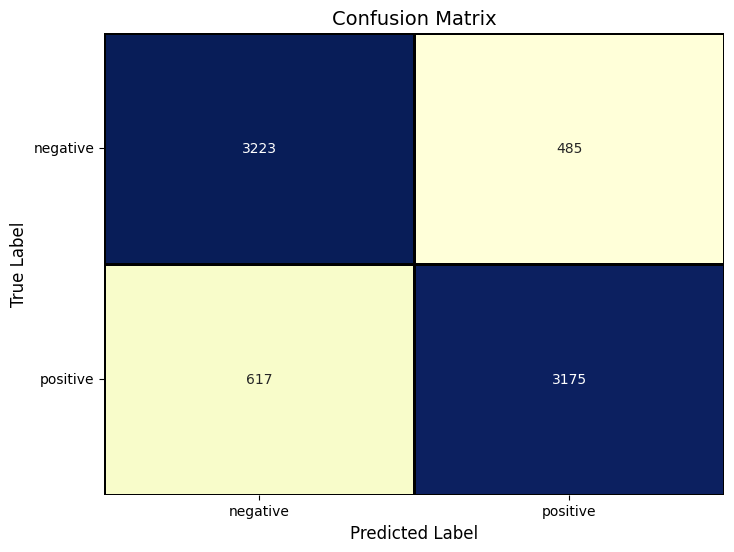

Classification Report:
              precision    recall  f1-score   support

    negative     0.8393    0.8692    0.8540      3708
    positive     0.8675    0.8373    0.8521      3792

    accuracy                         0.8531      7500
   macro avg     0.8534    0.8532    0.8531      7500
weighted avg     0.8536    0.8531    0.8531      7500



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False, linewidths=1, linecolor='black')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(ticks=np.arange(len(label_encoder.classes_)) + 0.5, labels=label_encoder.classes_, rotation=0)
plt.yticks(ticks=np.arange(len(label_encoder.classes_)) + 0.5, labels=label_encoder.classes_, rotation=0)
plt.show()

# Display the classification report
report = classification_report(y_test, predicted_labels, target_names=label_encoder.classes_, digits=4)
print("Classification Report:")
print(report)


**13. Visualizing Training Progress**

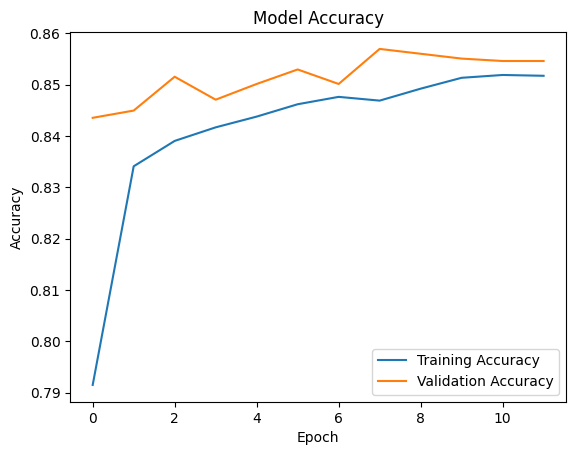

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

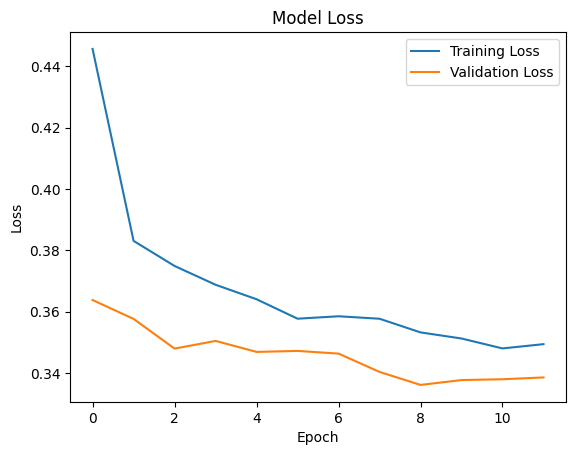

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()